# Deep-learning based label transfer using scvi-tools

In [1]:
import numpy as np
import pynndescent
import torch
import torch.nn as nn
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt

import scvi
import scanpy as sc
import anndata

/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


In [2]:
DATA_DIR = "/Users/jhjiang/Oxford/Results/multiome/scVI/data/"
RES_DIR = "/Users/jhjiang/Oxford/Results/multiome/scVI/results/"

## 1. Train a semi-supervised macrophage classifier with all plaque macrophages

Macrophage populations were annotated previously from the integration and clustering analysis using Seurat's CCA algorithm.

In [4]:
# load the plaque macrophage atlas as the reference
ref = sc.read_h5ad(DATA_DIR + "MP_Plaque.Nov2023.h5ad")
ref.layers["counts"] = ref.X.copy()
ref

AnnData object with n_obs × n_vars = 20458 × 39997
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'orig.indet', 'study_id', 'percent.mt', 'pANN.scores', 'DF.classifications', 'RNA_snn_res.0.1', 'seurat_clusters', 'RNA_clusters', 'cell_type', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'subtype'
    obsm: 'umap'
    layers: 'counts'

In [5]:
# select highly variable genes and only use these same genes for the query
sc.pp.log1p(ref)
sc.pp.highly_variable_genes(ref, n_top_genes=5000, batch_key="batch", subset=True)

In [6]:
scvi.model.SCANVI.setup_anndata(ref, batch_key="batch",  labels_key="subtype",unlabeled_category="Unknown", layer="counts")

/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [7]:
model_ref = scvi.model.SCANVI(ref)
model_ref.train(use_gpu=False, accelerator="cpu", check_val_every_n_epoch=1, max_epochs=100, train_size=0.8)

INFO     Training for 100 epochs.                                                                                  


/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



Epoch 100/100: 100%|██████████| 100/100 [11:59<00:00,  7.17s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.73e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [11:59<00:00,  7.20s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.73e+3]


### Evaluate model performance

In [8]:
# get training loss
df_loss_train = pd.DataFrame(
    {k:model_ref.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_accuracy' ]}
)
df_loss_train.columns = ['reconstruction_loss', 'kl_local', 'kl_global', 'accuracy']
df_loss_train['epoch'] = df_loss_train.index

# get validation loss
df_loss_val = pd.DataFrame(
    {k:model_ref.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'validation_accuracy' ]}
)
df_loss_val.columns = ['reconstruction_loss', 'kl_local', 'kl_global', 'accuracy']
df_loss_val['epoch'] = df_loss_train.index

# overall loss
df_loss = pd.concat([df_loss_train, df_loss_val])
df_loss['group'] = pd.Categorical(
    np.repeat(['Train', 'Validation'], 100),
    categories=['Train', 'Validation'],
    ordered=True
)

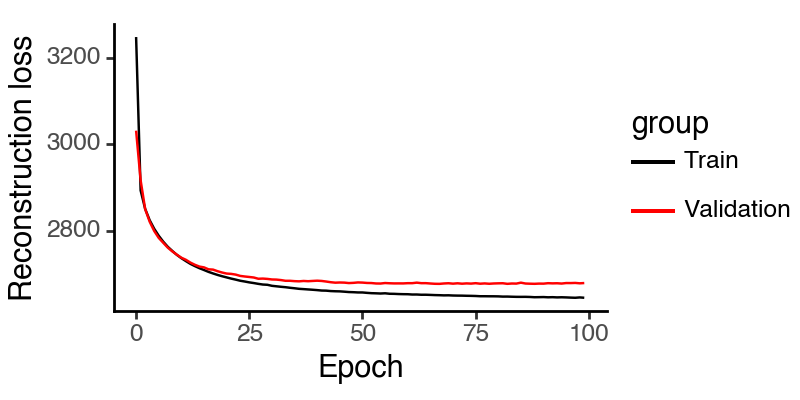

<Figure Size: (400 x 200)>

In [9]:
(
    ggplot(df_loss, aes(x = 'epoch', y = 'reconstruction_loss', color = 'group')) +
        geom_line() + 
        labs(x = 'Epoch', y = 'Reconstruction loss', color = 'group') + 
        scale_color_manual(values={
            'Train': 'black', 'Validation': 'red'
        }) + 
        theme_classic() + 
        theme(figure_size=(4,2))
)

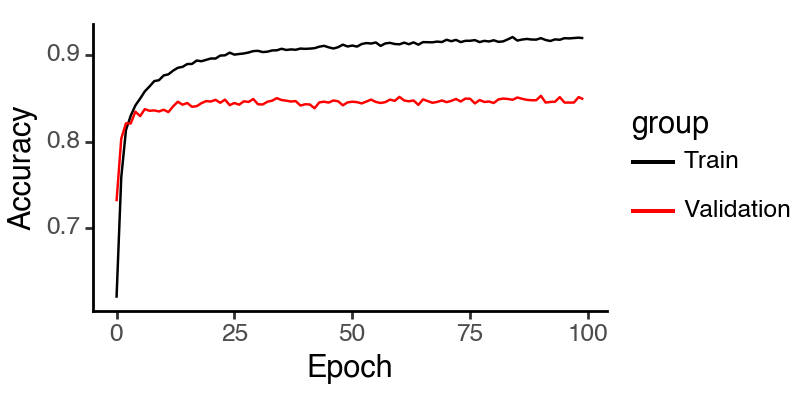

<Figure Size: (400 x 200)>

In [10]:
(
    ggplot(df_loss, aes(x = 'epoch', y = 'accuracy', color = 'group')) +
        geom_line() + 
        labs(x = 'Epoch', y = 'Accuracy', color = 'group') + 
        scale_color_manual(values={
            'Train': 'black', 'Validation': 'red'
        }) + 
        theme_classic() + 
        theme(figure_size=(4,2))
)

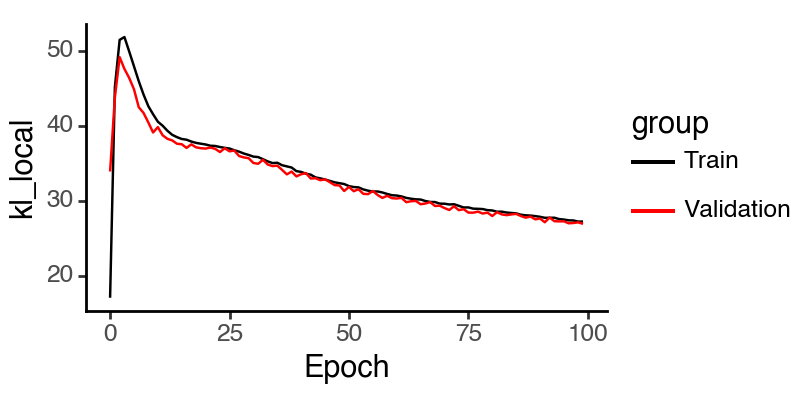

<Figure Size: (400 x 200)>

In [11]:
(
    ggplot(df_loss, aes(x = 'epoch', y = 'kl_local', color = 'group')) +
        geom_line() + 
        labs(x = 'Epoch', y = 'kl_local', color = 'group') + 
        scale_color_manual(values={
            'Train': 'black', 'Validation': 'red'
        }) + 
        theme_classic() + 
        theme(figure_size=(4,2))
)

### Prediction on the original data

In [12]:
ref.obsm["X_scVI"] = model_ref.get_latent_representation()
ref.obs["pred_label"] = model_ref.predict()

/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


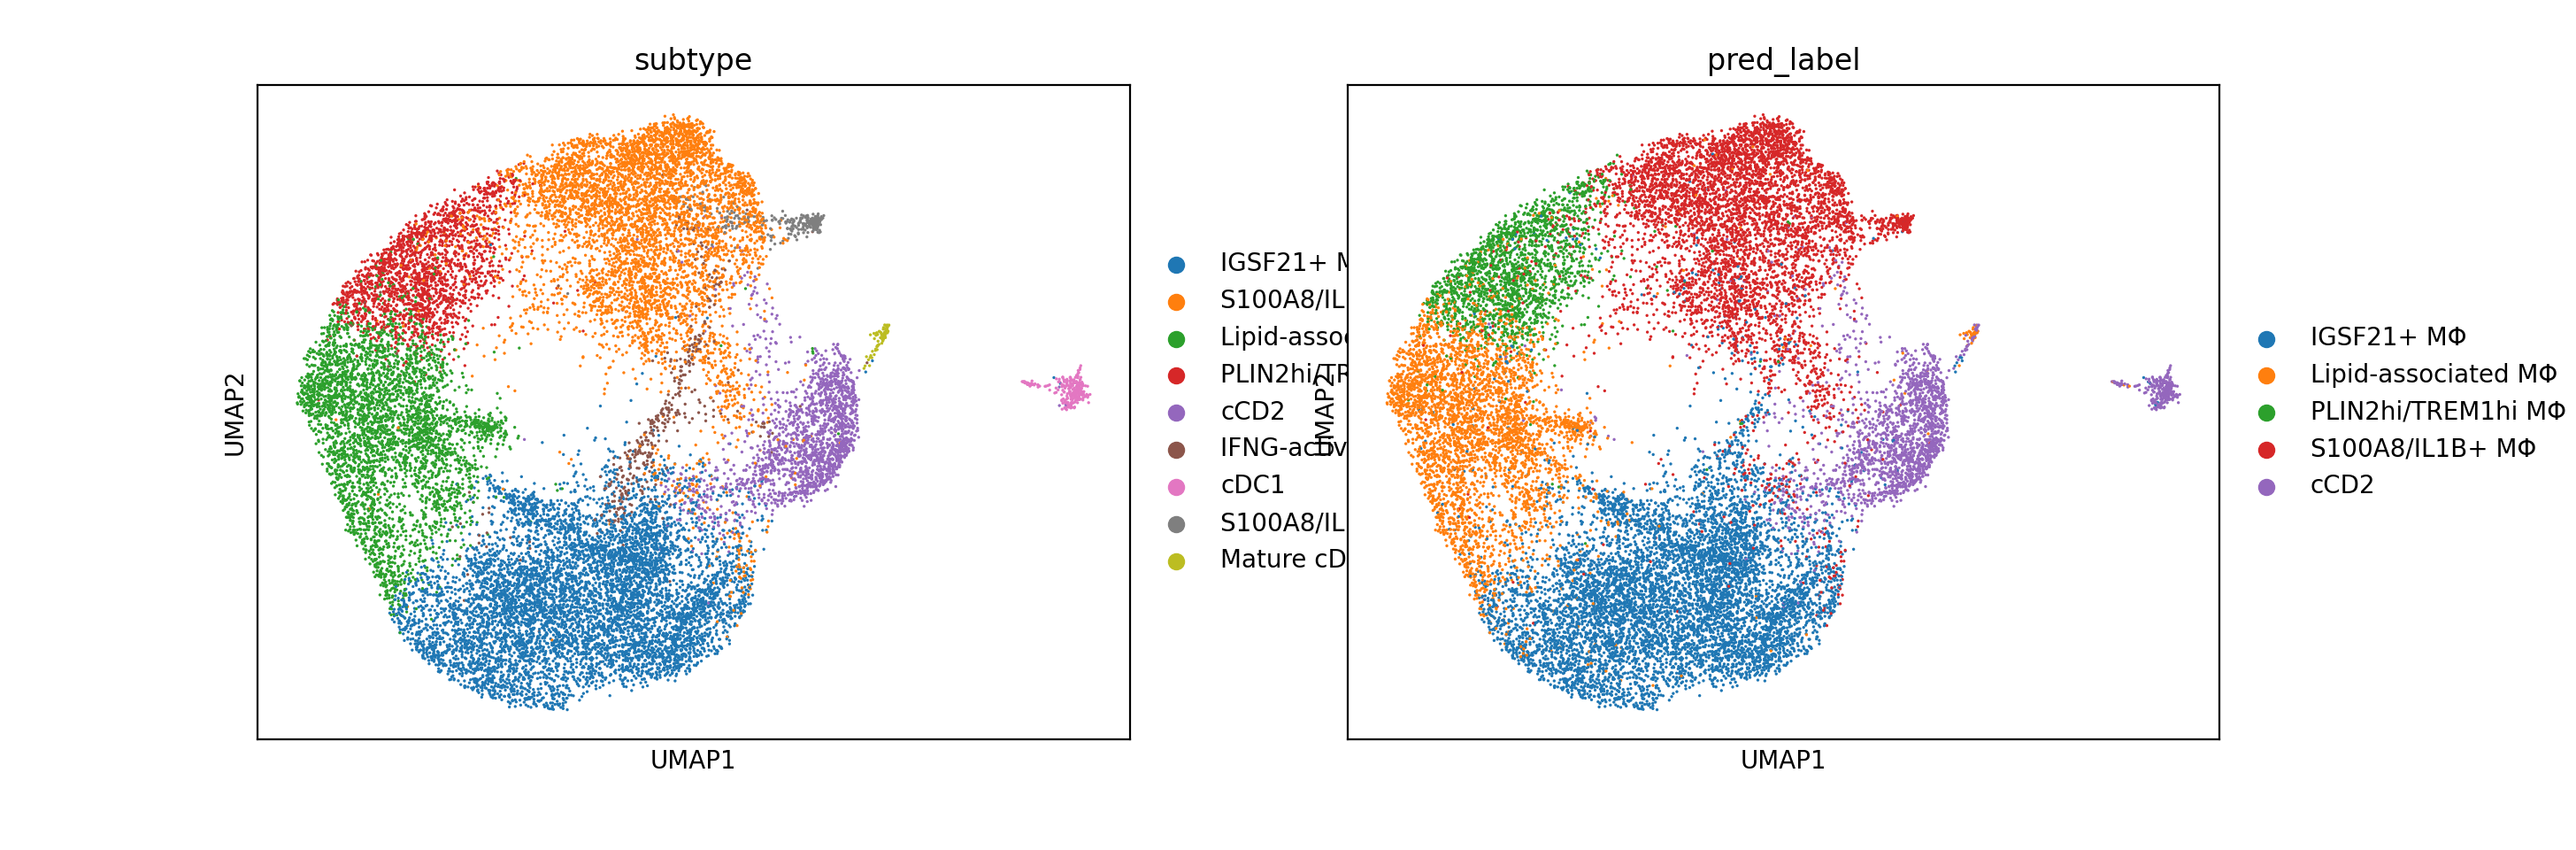

In [13]:
sc.pl.umap(ref, color=["subtype", "pred_label"])

### Save the trained model

In [14]:
model_ref.save(RES_DIR + "MP_Plaque.Nov2023", overwrite=True)

In [15]:
model_ref = scvi.model.SCANVI.load(RES_DIR + "MP_Plaque.Nov2023", ref)

INFO     File /Users/jhjiang/Oxford/Results/multiome/scVI/results/MP_Plaque.Nov2023/model.pt already downloaded    


## Predict labels for ex vivo macrophages

### Prepare query data (reorder genes and pad missing genes with 0)

In [12]:
query = sc.read_h5ad(DATA_DIR + "MP_oxldl.Nov2023.h5ad")
query.layers["counts"] = query.X.copy()

In [13]:
scvi.model.SCANVI.prepare_query_anndata(query, RES_DIR + "MP_Plaque.Nov2023")

INFO     File /Users/jhjiang/Oxford/Results/multiome/scVI/results/MP_Plaque.Nov2023/model.pt already downloaded    
INFO     Found 100.0% reference vars in query data.                                                                


In [14]:
model_query = scvi.model.SCANVI.load_query_data(query,RES_DIR + "MP_Plaque.Nov2023")

INFO     File /Users/jhjiang/Oxford/Results/multiome/scVI/results/MP_Plaque.Nov2023/model.pt already downloaded    


/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/_manager.py:216: UserWarning: Missing labels key subtype. Filling in with unlabeled category Unknown.


/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jhjiang/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


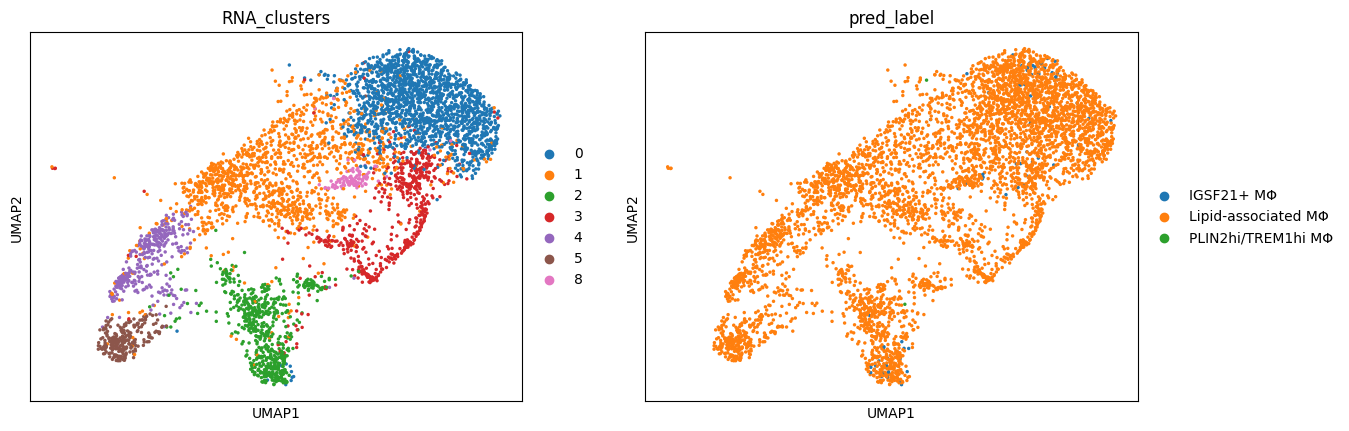

In [15]:
query.obs["pred_label"] = model_query.predict()
sc.pl.umap(query, color=["RNA_clusters", "pred_label"])

In [16]:
df_pred = model_query.predict(soft=True)

In [17]:
df_pred.to_csv(RES_DIR + "MP_oxldl.Nov2023.pred.csv")